In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import calendar
from datetime import timedelta
import json
import boto3

# Import and Explore Data
If you'd like to follow along, go to https://agile.octopushome.net/historical-data and download data from 2024-01-01 to 2025-09-21 and place the csv in the current working directory. I am using only export price timeseries but DeepAR models can be trained on multiple timeseries data so feel free to also used import price in training/test datasets. 

In [3]:
# load dataset from disk
df = pd.read_csv("agile-half-hour-actual-rates-01-01-2024_21-09-2025.csv",index_col=0).drop(columns =['Period to','Agile Import price (p/kWh)'])
df.index = pd.to_datetime(df.index,format="%d/%m/%Y %H:%M")
df['Agile Export price (p/kWh)'] = pd.to_numeric(df['Agile Export price (p/kWh)'],errors='coerce')

In [4]:
df.isna().any(axis=1)

Period from
2024-01-01 00:00:00    False
2024-01-01 00:30:00    False
2024-01-01 01:00:00    False
2024-01-01 01:30:00    False
2024-01-01 02:00:00    False
                       ...  
2025-09-21 21:30:00    False
2025-09-21 22:00:00    False
2025-09-21 22:30:00    False
2025-09-21 23:00:00     True
2025-09-21 23:30:00     True
Length: 30236, dtype: bool

In [5]:
# identify na rows
na_rows = df[df.isna().any(axis=1)]
print(na_rows)

                     Agile Export price (p/kWh)
Period from                                    
2025-09-21 23:00:00                         NaN
2025-09-21 23:30:00                         NaN


In [6]:
# since these two rows are at the end of our dataset, we can get rid of them without it affecting the continuity of our training set
n_rows = len(df)
df=df.dropna()
print(f"{n_rows-len(df)} rows dropped")

2 rows dropped


In [7]:
# no unusual statistics so we're good to move on
df.describe()

,Agile Export price (p/kWh)
count,30234.000000
mean,8.778688
std,4.158710
min,0.000000
25%,6.890000
50%,8.300000
75%,10.140000
max,92.020000


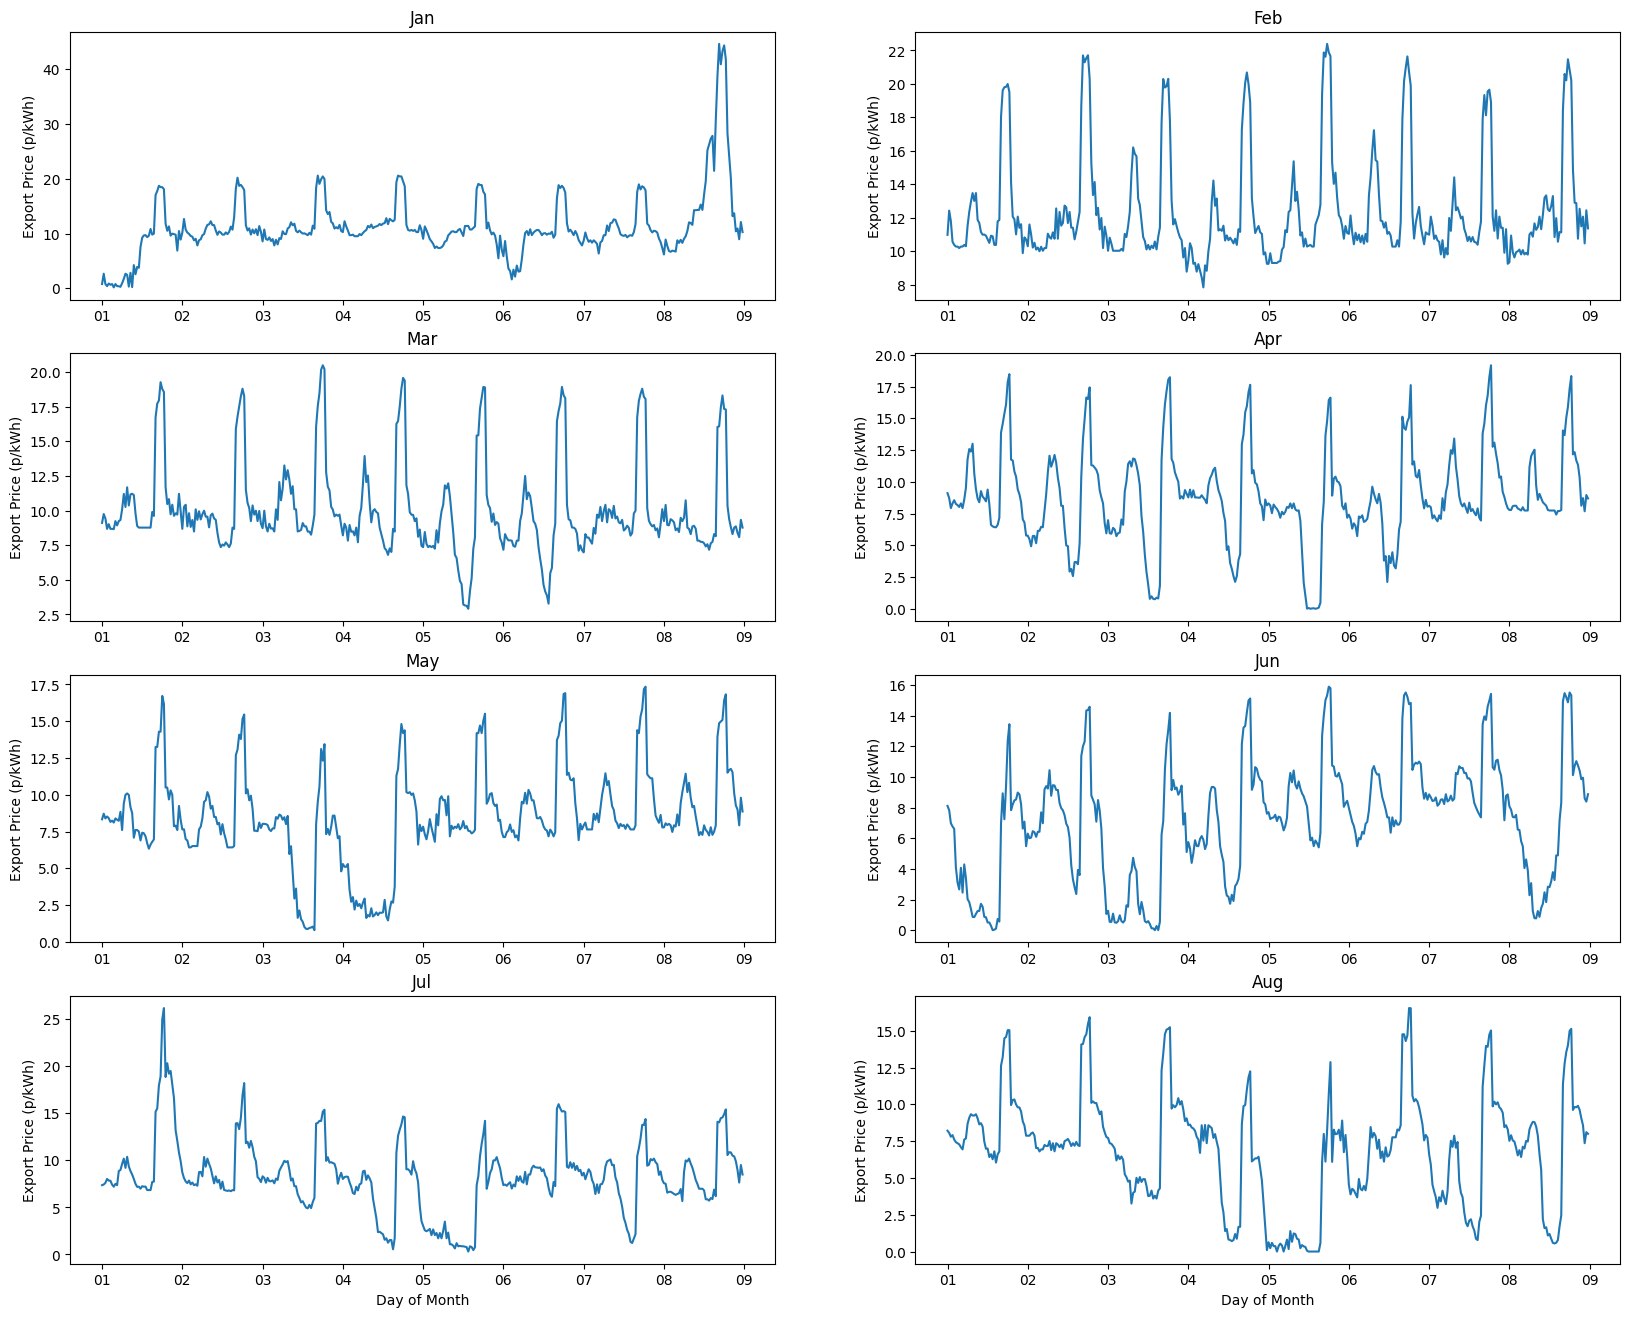

In [8]:
fig,axs = plt.subplots(4,2,figsize=(20,16))
axx = axs.ravel()
for m in range(8):
    axx[m].plot(df.loc[f"2025-{m+1}-01":f"2025-{m+1}-08"])
    axx[m].set_title(calendar.month_abbr[m+1])
    axx[m].set_ylabel('Export Price (p/kWh)')
    axx[m].xaxis.set_major_formatter(mdates.DateFormatter("%d"))
axx[6].set_xlabel('Day of Month')
axx[7].set_xlabel('Day of Month')

plt.show()

# Train and Test splits

In [9]:
start_date = pd.Timestamp("2024-01-01 00:00:00") 
end_training = pd.Timestamp("2024-08-29 00:00:00")

prediction_length = 7 * 48 # 7 days
context_length = 7 * 48 # 7 days
num_test_windows = 4

In [43]:
# UPDATE: this next cell does not define test_data properly, instead of "timedelta(days=k*prediction_length)", it should read "timedelta(weeks=k)"

In [10]:
training_data = [
    {
        "start": str(start_date),
        "target": df[start_date:end_training].iloc[:,0].tolist()
        }
]

test_data = [
    {
        "start": str(start_date),
        "target": df[start_date:end_training + timedelta(days=k*prediction_length)].iloc[:,0].tolist()  
 } 
 for k in range(1,num_test_windows+1)
 ]

print("Length of training data: ",len(training_data))
print("Length of test data: ",len(test_data))

Length of training data:  1
Length of test data:  4


In [11]:
def write_dicts_to_file(path,data):
    """
    Serialises and converts data to binary format before writing to a json file at path 'path'
    """
    with open(path,"wb") as f:
        for d in data:
            f.write(json.dumps(d).encode("utf-8"))
            f.write("\n".encode())

In [12]:
write_dicts_to_file('train.json',training_data)
write_dicts_to_file('test.json',test_data)

In [13]:
df

,Agile Export price (p/kWh)
Period from,
2024-01-01 00:00:00,4.17
2024-01-01 00:30:00,5.67
2024-01-01 01:00:00,7.34
2024-01-01 01:30:00,4.08
2024-01-01 02:00:00,3.71
...,...
2025-09-21 20:30:00,9.67
2025-09-21 21:00:00,9.80
2025-09-21 21:30:00,6.80


In [25]:
# I have created a s3 bucket called "" 
# save df as csv 
df.to_csv('data.csv',index=True)

# save csv to s3 bucket for comparison with predictions later
session = boto3.Session(profile_name='iamadmin-naresh')
s3 = session.client('s3')
bucket_name = 'sagemaker-octopus-price-predictor'
object_key = 'data/data.csv'
s3.upload_file('data.csv',bucket_name,object_key)

In [31]:
end_training

Timestamp('2024-08-29 00:00:00')

In [30]:
df[start_date:end_training]

,Agile Export price (p/kWh)
Period from,
2024-01-01 00:00:00,4.17
2024-01-01 00:30:00,5.67
2024-01-01 01:00:00,7.34
2024-01-01 01:30:00,4.08
2024-01-01 02:00:00,3.71
...,...
2024-08-28 22:00:00,8.57
2024-08-28 22:30:00,8.60
2024-08-28 23:00:00,7.76


In [44]:
df[start_date:end_training]


,Agile Export price (p/kWh)
Period from,
2024-01-01 00:00:00,4.17
2024-01-01 00:30:00,5.67
2024-01-01 01:00:00,7.34
2024-01-01 01:30:00,4.08
2024-01-01 02:00:00,3.71
...,...
2024-08-28 22:00:00,8.57
2024-08-28 22:30:00,8.60
2024-08-28 23:00:00,7.76
